(4)=
# 4 Modelling Anomalies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.animation as animation
import IPython.display as ipy
from IPython.display import HTML
from IPython import display

from eda_helper import sliding_windows, plot_windows

In [2]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = "../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = "../output/tables/4/"
OUTPUT_FIGURES_PATH = "../output/figures/4/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap

custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, "east_df.pkl"))
west_df = pd.read_pickle(os.path.join(DATA_PATH, "west_df.pkl"))

west_complete_days_df = pd.read_pickle(
    os.path.join(DATA_PATH, "west_complete_days_df.pkl")
)

In [3]:
COMPLETENESS_THRESHOLD = 1

from eda_helper import preprocess_data

east_dict = preprocess_data(east_df, COMPLETENESS_THRESHOLD)
east_timeseries = east_dict["data"]

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 100% completeness: 15744
Proportion of records removed: 60.55%
Maximum consecutive days: 9
Starting from day number 205 in 2022


In [4]:
east_timeseries.max(), east_timeseries.min()

(3.6195769704717007, -1.0)

In [5]:
len(east_timeseries)

864

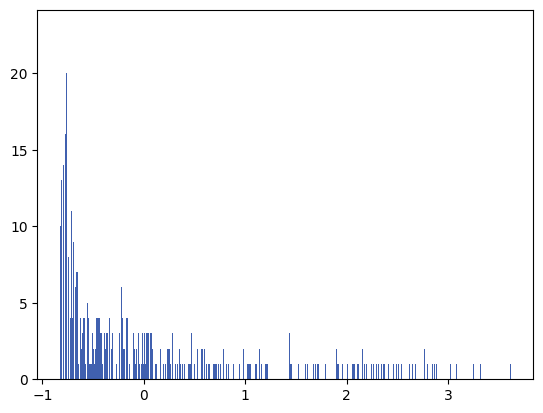

In [6]:
plt.hist(x=east_timeseries[:, 0], bins=1000)
plt.show()

In [7]:
def create_anomaly_column(timeseries_array: np.ndarray) -> np.ndarray:
    # Create a new boolean column where True indicates that the value in the first column is greater than 0.9
    anomaly = timeseries_array[:, 0] > 0.9
    # Reshape the new column to be two-dimensional so it can be concatenated with the original array
    anomaly = anomaly.reshape(-1, 1)
    # Concatenate the new column to your array along axis 1
    timeseries_array = np.concatenate((timeseries_array, anomaly), axis=1)
    return timeseries_array

In [8]:
east_anomaly_timeseries = create_anomaly_column(east_timeseries)

In [9]:
east_anomaly_timeseries[:, 11].sum()

147.0

(4.1)=
## 4.1 Select Modelling Technique

Outline the types of models you are considering for the project. For this case, you're considering using a Long Short-Term Memory (LSTM) neural network model for time-series prediction.

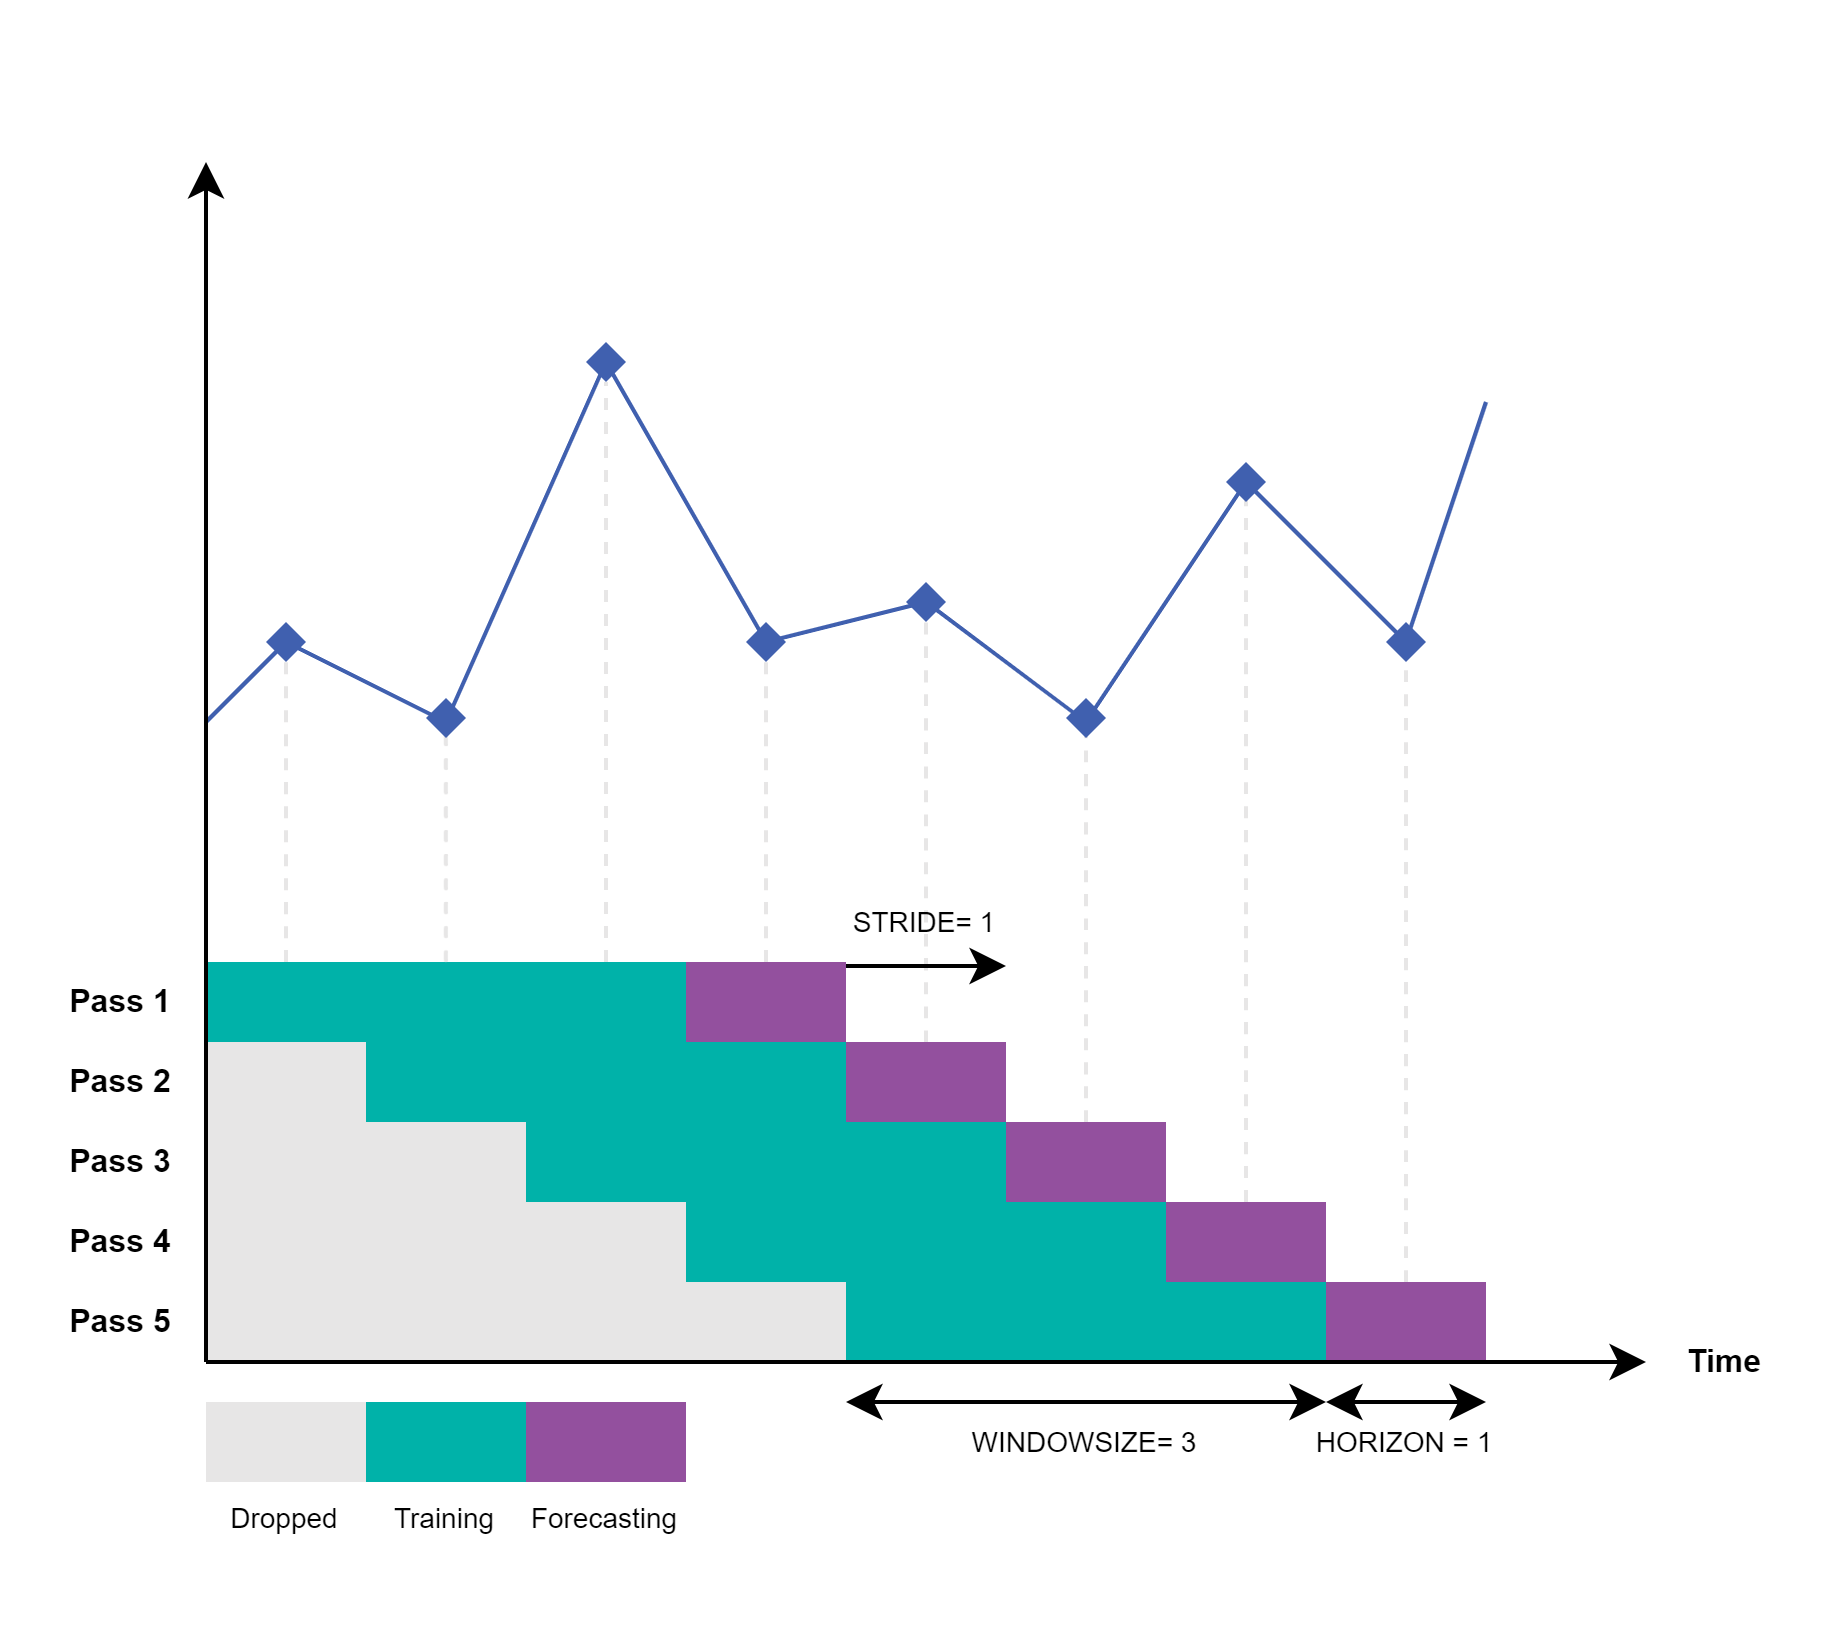

In [10]:
display.Image(
    os.path.join(os.getcwd(), "graphics\sliding_window_w3h3s1.png"),
    width=768,
    height=768,
)

### Model 0: Baseline

For our baseline model we are using a linear model that is trained on the 10 input features that we have created in part 3.

In [11]:
# List of indices for the input features
INPUT_INDICES = list(range(0, 11))  # input features are the last 10 features
# Index of the target feature
TARGET_INDEX = 0  # target feature is the first feature

In [12]:
INPUT_INDICES, TARGET_INDEX

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 0)

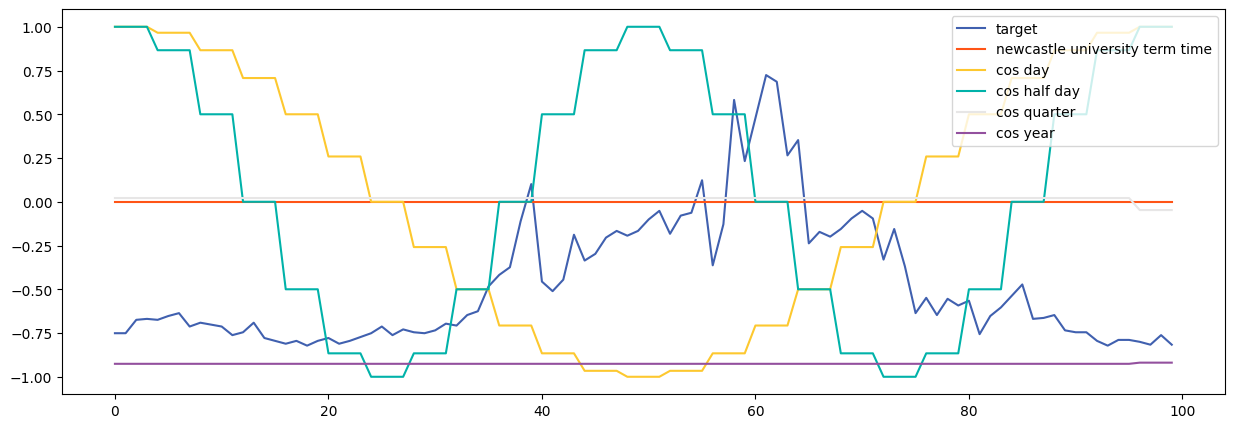

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(east_timeseries[:100, 0], label="target")
plt.plot(east_timeseries[:100, 1], label="newcastle university term time")
# plt.plot(east_timeseries[:100, 2], label="northumbria")
# plt.plot(east_timeseries[:100,3], label='sin day')
plt.plot(east_timeseries[:100, 4], label="cos day")
# plt.plot(east_timeseries[:100,5], label='sin half day')
plt.plot(east_timeseries[:100, 6], label="cos half day")
# plt.plot(east_timeseries[:100,7], label='sin quarter')
plt.plot(east_timeseries[:100, 8], label="cos quarter")
# plt.plot(east_timeseries[:100,9], label='sin year')
plt.plot(east_timeseries[:100, 10], label="cos year")
# plt.title("Target and input features - first 100 rows")
plt.legend(loc="upper right")
plt.show()

In [14]:
train_size = int(len(east_timeseries) * 0.67)
test_size = len(east_timeseries) - train_size
train, test = east_timeseries[:train_size], east_timeseries[train_size:]

WINDOW_SIZE = 1  # must be one as we using a linear model
HORIZON = 1

train_inputs, train_targets = sliding_windows(
    train, WINDOW_SIZE, INPUT_INDICES, TARGET_INDEX, HORIZON
)
test_inputs, test_targets = sliding_windows(
    test, WINDOW_SIZE, INPUT_INDICES, TARGET_INDEX, HORIZON
)

print(
    f"Train input tensor: {train_inputs.shape} | Train target tensor: {train_targets.shape}"
)
print()
print(
    f"Test input tensor: {test_inputs.shape} | Test target tensor: {test_targets.shape}"
)


class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


# initialize the model
input_size = (
    1 if type(INPUT_INDICES) is int else len(INPUT_INDICES)
)  # number of input features
output_size = 1  # number of output features
model = LinearModel(input_size, output_size)

# for training the model:
criterion = nn.MSELoss()  # for regression
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# for the training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(train_inputs.float())
    loss = criterion(outputs, train_targets.unsqueeze(dim=1).float())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

# after training we get the weights:
weights = model.linear.weight.detach().numpy()
print("Weights:", weights)

with torch.inference_mode():
    predictions = model(test_inputs.float())

c:\#code\#python\#current\mres-project\analysis_files\eda_helper.py:474: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(inputs), torch.tensor(targets)
c:\#code\#python\#current\mres-project\.venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([577, 1])) that is different to the input size (torch.Size([577, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train input tensor: torch.Size([577, 1, 11]) | Train target tensor: torch.Size([577])

Test input tensor: torch.Size([285, 1, 11]) | Test target tensor: torch.Size([285])
Epoch: 0 | Loss: 1.05340576171875
Epoch: 100 | Loss: 0.9414047598838806
Epoch: 200 | Loss: 0.9385051131248474
Epoch: 300 | Loss: 0.9379225969314575
Epoch: 400 | Loss: 0.937699556350708
Weights: [[-0.04115599  0.03840703  0.1844526  -0.01952633 -0.04540199  0.01096399
   0.00834887  0.24049886 -0.28973225  0.16280283  0.12551574]]


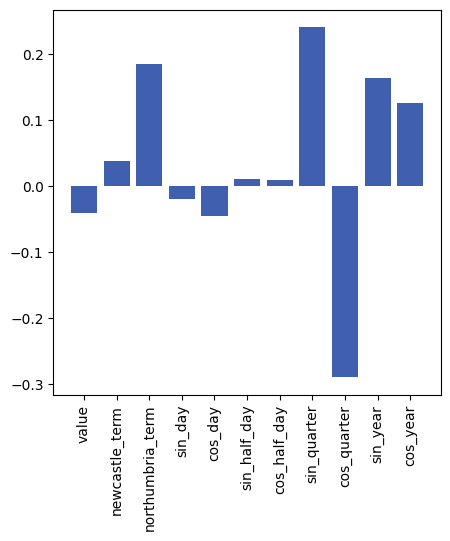

In [15]:
plt.figure(figsize=(5, 5))
plt.bar(x=east_dict["columns"][0:], height=weights.squeeze(), color=custom_palette[0])
plt.xticks(rotation=90)
# plt.title("Feature weights in the linear model")
plt.show()

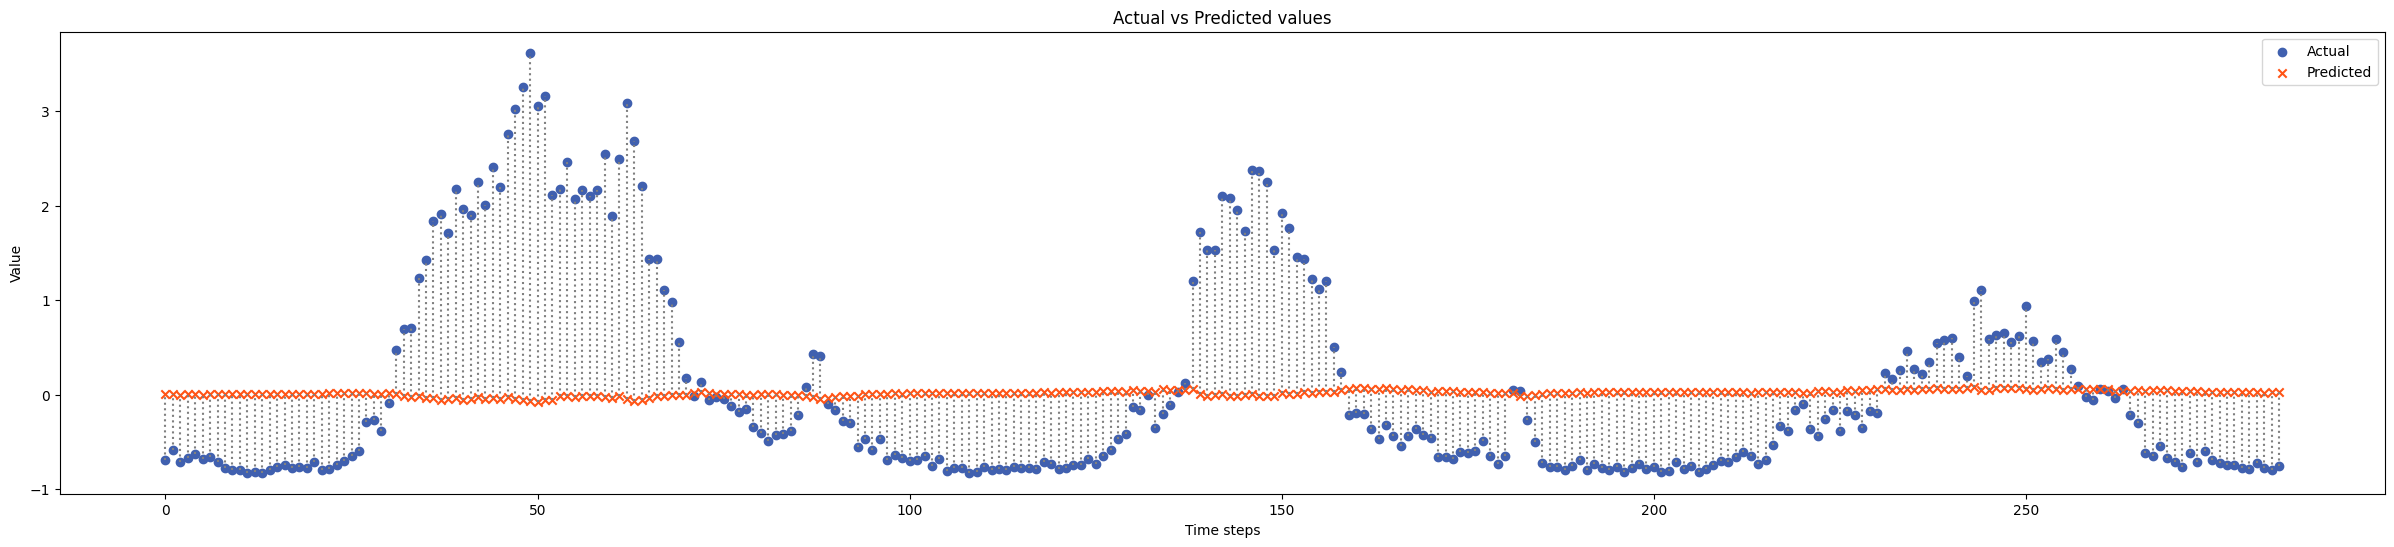

In [16]:
# Move predictions to CPU and convert to numpy
predictions_np = predictions.cpu().numpy()

# Similarly, move the test targets to CPU and convert to numpy
test_targets_np = test_targets.cpu().numpy()

# Create a plot
plt.figure(figsize=(30, 6))

# Plot the actual values
plt.scatter(
    range(len(test_targets_np)),
    test_targets_np,
    label="Actual",
    color=custom_palette[0],
    marker="o",
)

# Plot the predicted values
plt.scatter(
    range(len(test_targets_np)),
    predictions_np.squeeze()[0:],
    label="Predicted",
    color=custom_palette[1],
    marker="x",
)

# Add vertical lines
for i in range(len(test_targets_np)):
    plt.vlines(
        x=i,
        ymin=min(test_targets_np[i], predictions_np.squeeze()[i]),
        ymax=max(test_targets_np[i], predictions_np.squeeze()[i]),
        colors="gray",
        linestyles="dotted",
    )

# Create the legend and titles
plt.legend()
plt.title("Actual vs Predicted values")
plt.xlabel("Time steps")
plt.ylabel("Value")

# Display the plot
plt.show()

In [17]:
# Flattening predictions and targets for metric calculations
predictions_flat_np = predictions_np.flatten()
targets_flat_np = test_targets.flatten()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(targets_flat_np, predictions_flat_np)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(targets_flat_np, predictions_flat_np)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared (R²)
r2 = r2_score(targets_flat_np, predictions_flat_np)
print(f"R-squared (R²): {r2}")

# Create a dictionary with the metrics
metrics = {
    "Model": "Linear",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R^2": r2,
}

performance_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "R^2"])

# Append the dictionary to the DataFrame
metrics_df = pd.DataFrame(metrics, index=[0])
performance_df = pd.concat([performance_df, metrics_df])

# Print the DataFrame
print(performance_df.round(3))

Mean Absolute Error (MAE): 0.8280796782438022
Mean Squared Error (MSE): 1.160074815723514
Root Mean Squared Error (RMSE): 1.0770676931945893
R-squared (R²): -0.033939703406016264
    Model    MAE   MSE   RMSE    R^2
0  Linear  0.828  1.16  1.077 -0.034


### Model 1: LSTM

In [18]:
# set the data completeness threshold
COMPLETENESS_THRESHOLD = 0.94
# preprocess the raw data
east_dict = preprocess_data(east_df, COMPLETENESS_THRESHOLD)
# store the different keys of the dictionary in separate variables
east_timeseries = east_dict["data"]
east_columns = east_dict["columns"]
east_index = east_dict["index"]

# set the feature indices
INPUT_INDICES = list(range(0, 11))
# set the target index
TARGET_INDEX = 0
# set the window size
WINDOW_SIZE = 50
# set the horizon
HORIZON = 1
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
BATCH_SIZE = 8

# create the sliding windows
inputs, targets = sliding_windows(
    east_timeseries, WINDOW_SIZE, INPUT_INDICES, TARGET_INDEX, HORIZON
)

Removing incomplete days...
Initial number of records: 39904
Number of records in days @ 94% completeness: 32758
Proportion of records removed: 17.91%
Maximum consecutive days: 76
Starting from day number 1 in 2023


In [19]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]


# Split into train and test sets
train_size = int(len(inputs) * 0.8)  # 80% for training, 20% for testing
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]
# Divide the training data further into training and validation sets
train_size = int(len(train_inputs) * 0.8)  # 80% for training, 20% for validation
val_size = len(train_inputs) - train_size
train_inputs, val_inputs = train_inputs[:train_size], train_inputs[train_size:]
train_targets, val_targets = train_targets[:train_size], train_targets[train_size:]

# Creating datasets
train_dataset = TimeSeriesDataset(train_inputs, train_targets)
test_dataset = TimeSeriesDataset(test_inputs, test_targets)
val_dataset = TimeSeriesDataset(val_inputs, val_targets)

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(train_inputs.shape, test_inputs.shape)
print(train_targets.shape, test_targets.shape)

torch.Size([4602, 50, 11]) torch.Size([1439, 50, 11])
torch.Size([4602]) torch.Size([1439])


In [21]:
# Simplified Encoder (removed one of the LSTM layers)
class Encoder(nn.Module):
    def __init__(self, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.n_features = n_features
        self.embedding_dim = embedding_dim

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True,
        )

    def forward(self, x):
        x, (hidden_n, _) = self.rnn(x)
        return hidden_n.reshape((-1, self.embedding_dim))


# Simplified Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.n_features = n_features

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True,
        )

        self.output_layer = nn.Linear(input_dim, n_features)

    def forward(self, x):
        x = x.repeat_interleave(self.seq_len, dim=1)
        x = x.reshape(-1, self.seq_len, self.input_dim)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Use only the last output of the sequence
        return self.output_layer(x)


# Simplified Recurrent Autoencoder
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = RecurrentAutoencoder(WINDOW_SIZE, len(INPUT_INDICES), 64)
model = model.to(device)

In [22]:
# Function to run one training epoch
def train_one_epoch(model, optimizer, criterion, inputs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize the epoch loss to 0
    for i, (inputs, targets) in enumerate(train_dataloader):  # Loop over each input
        inputs = inputs.to(
            device
        ).float()  # Move the input to the correct device and ensure it's float
        targets = targets.to(
            device
        ).float()  # .squeeze()  # Move the target to the correct device and ensure it's float
        optimizer.zero_grad()  # Zero the gradients

        output = model(inputs).squeeze()  # Pass the input through the model
        loss = criterion(output, targets)  # Calculate the loss
        loss.backward()  # Calculate the gradients

        optimizer.step()  # Update the model parameters
        epoch_loss += loss.item()  # Add the loss for this input to the total epoch loss
    return epoch_loss / len(train_dataloader)  # Return the average epoch loss


# Function to test the model
def test_model(model, criterion, inputs):
    model.eval()  # Set the model to evaluation mode
    epoch_loss = 0.0  # Initialize the epoch loss to 0
    with torch.inference_mode():  # Ensure no gradients are calculated
        for i, (inputs, targets) in enumerate(
            test_dataloader
        ):  # Loop over each input in the dataloader
            inputs = inputs.to(
                device
            ).float()  # Move the input to the correct device and ensure it's float
            targets = targets.to(
                device
            ).float()  # .squeeze()  # Move the target to the correct device and ensure it's float
            output = model(inputs).squeeze()  # Pass the input through the model
            loss = criterion(output, targets)  # Calculate the loss
            epoch_loss += (
                loss.item()
            )  # Add the loss for this input to the total epoch loss
    return epoch_loss / len(test_dataloader)  # Return the average epoch loss


# Function to train the model
def train_model(model, train_inputs, test_inputs, epochs):
    torch.manual_seed(42)  # Set the seed for reproducibility
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.001
    )  # Initialize the optimizer
    criterion = nn.L1Loss(reduction="sum").to(device)  # Initialize the loss function
    history = dict(
        train=[], test=[]
    )  # Initialize a dictionary to hold the training and testing history

    best_model_wts = copy.deepcopy(model.state_dict())  # Copy the initial model weights
    best_loss = 10000.0  # Initialize the best loss to a large number

    for epoch in range(epochs):  # Loop over each epoch
        train_loss = train_one_epoch(
            model, optimizer, criterion, train_inputs
        )  # Train the model for one epoch
        test_loss = test_model(model, criterion, test_inputs)  # Test the model

        history["train"].append(train_loss)  # Add the training loss to the history
        history["test"].append(test_loss)  # Add the testing loss to the history

        # If the testing loss is lower than the best loss, update the best loss and best model weights
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        if epoch % 5 == 0:
            print(
                f"Epoch {epoch} | Train loss {train_loss} | Test loss {test_loss}"
            )  # Print the training and testing losses

    model.load_state_dict(best_model_wts)  # Load the best model weights
    return model.eval(), history  # Return the model and the training history

In [23]:
# training the model
model, history = train_model(model, train_dataloader, test_dataloader, epochs=50)

c:\#code\#python\#current\mres-project\.venv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (11) must match the size of tensor b (8) at non-singleton dimension 1

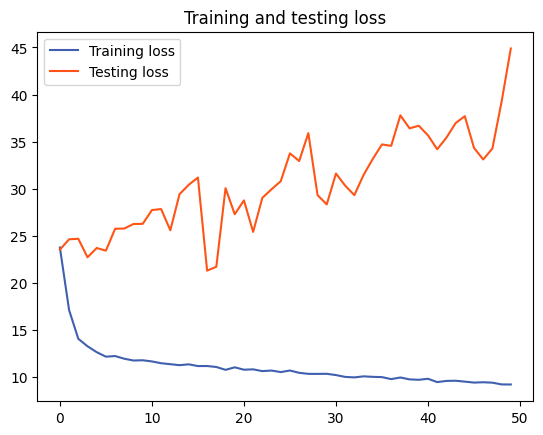

In [ ]:
plt.plot(history["train"], label="Training loss")
plt.plot(history["test"], label="Testing loss")
plt.title("Training and testing loss")
plt.legend()

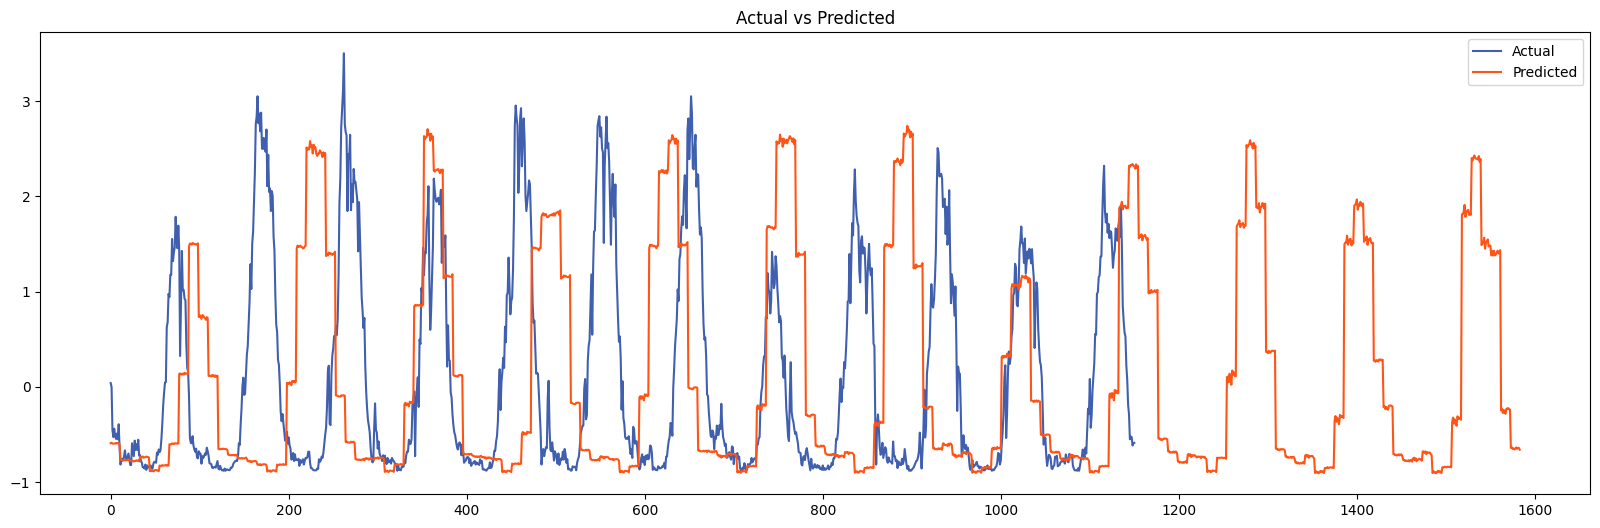

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Store all predictions and actual values
all_preds = []
all_actuals = []

# Iterate over validation data
for batch in val_dataloader:
    # assuming your batch is a tuple (data, target)
    data, target = batch

    # Move data and target to device
    data, target = data.float().to(device), target.float().to(device)

    # Make predictions
    with torch.no_grad():
        output = model(data)

    # Move prediction and target to cpu
    output, target = output.cpu(), target.cpu()

    # Append the model output and target to respective lists
    all_preds.append(output.numpy()[-1])
    all_actuals.append(target.numpy())

# Concatenate all the batched predictions and actual values
all_preds = np.concatenate(all_preds, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

# Plot actuals and predictions
plt.figure(figsize=(20, 6))
plt.plot(all_actuals, label="Actual")
plt.plot(all_preds, label="Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
for batch in test_dataloader:
    inputs, targets = batch
    print(inputs[0], targets[0])

tensor([0.0000, 0.0025, 0.0147, 0.0074, 0.0098], dtype=torch.float64) tensor([0.0061], dtype=torch.float64)
tensor([0.0123, 0.0098, 0.0258, 0.0197, 0.0086], dtype=torch.float64) tensor([0.0123], dtype=torch.float64)
tensor([0.0319, 0.0209, 0.0405, 0.0553, 0.0799], dtype=torch.float64) tensor([0.0934], dtype=torch.float64)
tensor([0.1855, 0.1057, 0.1388, 0.1609, 0.1929], dtype=torch.float64) tensor([0.2138], dtype=torch.float64)
tensor([0.5307, 0.5295, 0.6585, 0.6536, 0.6253], dtype=torch.float64) tensor([0.5762], dtype=torch.float64)
tensor([0.6916, 0.5307, 0.6179, 0.5835, 0.5147], dtype=torch.float64) tensor([0.5098], dtype=torch.float64)
tensor([0.4558, 0.2998, 0.2408, 0.1376, 0.1425], dtype=torch.float64) tensor([0.1388], dtype=torch.float64)
tensor([0.1143, 0.0872, 0.0639, 0.0885, 0.1032], dtype=torch.float64) tensor([0.0909], dtype=torch.float64)
tensor([0.0381, 0.0332, 0.0491, 0.0479, 0.0528], dtype=torch.float64) tensor([0.0749], dtype=torch.float64)
tensor([0.0393, 0.1966, 0.19

In [ ]:
def compute_reconstruction_error(model, data_loader):
    reconstruction_errors = []
    with torch.inference_mode():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = model(inputs)
            reconstruction_errors.extend(
                torch.nn.functional.mse_loss(outputs, inputs, reduction="none")
                .mean(-1)
                .cpu()
                .numpy()
            )
    return np.array(reconstruction_errors)


# Compute reconstruction errors on your normal validation set
reconstruction_errors_val = compute_reconstruction_error(model, val_dataloader)

# Set your threshold
threshold = np.percentile(reconstruction_errors_val, 95)

# Now compute the errors in the test set
reconstruction_errors_test = compute_reconstruction_error(model, test_dataloader)

# Anomalies are where the reconstruction error crosses your threshold
anomalies = reconstruction_errors_test > threshold

AttributeError: 'list' object has no attribute 'to'

(4.2)=
## 4.2 Generate Test Design

Discuss how you will evaluate your model's performance. For time-series data, this could involve setting aside a portion of your dataset for validation or using techniques like time-series cross-validation.

(4.4)=
## 4.4 Model Assumptions

Discuss any assumptions that your model makes. For example, LSTMs assume that future values can be predicted from past values, which may not always be accurate.

(4.5)=
## 4.5 Model Training

Document the process of training your model. Include any details about the learning rate, loss function, optimizer, number of epochs, etc. Also, include any details about the training process itself, like the hardware used, how long it took, any challenges you encountered, etc.

(4.6)=
## 4.6 Model Evaluation

Detail the performance of your model on the validation dataset. Discuss any metrics you used to evaluate the model's performance (like MSE, MAE, etc.), and why you chose these metrics. Also, discuss how the model performed with respect to these metrics, and any steps you took to improve its performance (like tuning hyperparameters, adjusting the model architecture, etc.).

(4.7)=
## 4.7 Model Interpretation and Visualisation

Interpret the predictions made by your model, and discuss any insights they may provide. If possible, visualise these predictions using appropriate plots.

(4.8)=
## 4.8 Model Validation

Discuss any additional steps you took to validate your model's performance. This could include applying it to an independent test set, checking its performance against a simpler model, or verifying its results with a domain expert.

(4.9)=
## 4.9 Challenges and Learnings

Discuss any challenges faced during the model building and evaluation process and how you overcame them. Mention what you learned during this process.

(4.10)=
## 4.10 Conclusion and Next Steps...

Summarize your findings, the performance of your model, and potential next steps. This could include ideas for improving the model's performance, plans for deploying the model, or other tasks that could build upon your current work.